In [3]:
# Importação de bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, confusion_matrix, 
                           classification_report, multilabel_confusion_matrix)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Configuração de visualização
plt.style.use('ggplot')
sns.set_palette("Set2")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

In [5]:
# Carregamento dos dados
df = pd.read_csv('bootcamp_train.csv')

In [6]:
# Análise exploratória inicial
print("=== ANÁLISE EXPLORATÓRIA INICIAL ===\n")
print(f"Shape do dataset: {df.shape}")
print(f"\nPrimeiras 5 linhas:")
print(df.head())
print(f"\nInformações do dataset:")
print(df.info())
print(f"\nEstatísticas descritivas:")
print(df.describe())
print(f"\nValores nulos por coluna:")
print(df.isnull().sum())
print(f"\nValores únicos por coluna:")
print(df.nunique())

=== ANÁLISE EXPLORATÓRIA INICIAL ===

Shape do dataset: (35260, 15)

Primeiras 5 linhas:
   id id_produto tipo  temperatura_ar  temperatura_processo  umidade_relativa  velocidade_rotacional  torque  desgaste_da_ferramenta falha_maquina FDF (Falha Desgaste Ferramenta) FDC (Falha Dissipacao Calor) FP (Falha Potencia)  FTE (Falha Tensao Excessiva) FA (Falha Aleatoria)
0   0     L56434    L           298.3                 309.1              90.0                 1616.0    31.1                   195.0           não                           False                        False                 Não                         False                  Não
1   1     L48741    L           298.2                 308.4              90.0                 1388.0    53.8                   137.0           Não                           False                        False                 Não                         False                  Não
2   2     L48850    L           298.2                 307.8              9

In [7]:
# Análise das colunas categóricas
print(f"\nValores únicos nas colunas categóricas:")
categorical_cols = ['tipo', 'falha_maquina', 'FDF (Falha Desgaste Ferramenta)', 
                   'FDC (Falha Dissipacao Calor)', 'FP (Falha Potencia)', 
                   'FTE (Falha Tensao Excessiva)', 'FA (Falha Aleatoria)']

for col in categorical_cols:
    if col in df.columns:
        print(f"{col}: {df[col].unique()}")


Valores únicos nas colunas categóricas:
tipo: ['L' 'M' 'H']
falha_maquina: ['não' 'Não' 'sim' 'N' '0' 'Sim' 'y' '1']
FDF (Falha Desgaste Ferramenta): ['False' 'N' '0' 'True' '-' '1']
FDC (Falha Dissipacao Calor): ['False' 'nao' '0' 'True' 'y' '1']
FP (Falha Potencia): ['Não' 'não' 'Sim' 'N' '0' 'sim' '1' 'y']
FTE (Falha Tensao Excessiva): [False  True]
FA (Falha Aleatoria): ['Não' 'não' '0' '-' 'Sim' 'sim' '1']


In [8]:
# Verificação de valores inconsistentes
print(f"\nValores inconsistentes encontrados:")
for col in df.columns:
    if df[col].dtype == 'object':
        unique_vals = df[col].unique()
        problematic_vals = [val for val in unique_vals if str(val).lower() in ['n', 'não', 'nao', 'não', 'n', 'false', 'f', '0', 'sim', 's', 'true', 't', '1', 'y', 'yes']]
        if problematic_vals:
            print(f"{col}: {problematic_vals}")


Valores inconsistentes encontrados:
falha_maquina: ['não', 'Não', 'sim', 'N', '0', 'Sim', 'y', '1']
FDF (Falha Desgaste Ferramenta): ['False', 'N', '0', 'True', '1']
FDC (Falha Dissipacao Calor): ['False', 'nao', '0', 'True', 'y', '1']
FP (Falha Potencia): ['Não', 'não', 'Sim', 'N', '0', 'sim', '1', 'y']
FA (Falha Aleatoria): ['Não', 'não', '0', 'Sim', 'sim', '1']


In [9]:
# Função para limpar valores inconsistentes
def clean_inconsistent_values(value):
    if pd.isna(value):
        return value
    value_str = str(value).lower().strip()
    if value_str in ['n', 'não', 'nao', 'false', 'f', '0']:
        return 0
    elif value_str in ['sim', 's', 'true', 't', '1', 'y', 'yes']:
        return 1
    else:
        return value

In [10]:
# Aplicar limpeza nas colunas categóricas problemáticas
cols_to_clean = ['falha_maquina', 'FDF (Falha Desgaste Ferramenta)', 
                'FDC (Falha Dissipacao Calor)', 'FP (Falha Potencia)', 
                'FTE (Falha Tensao Excessiva)', 'FA (Falha Aleatoria)']

for col in cols_to_clean:
    if col in df.columns:
        df[col] = df[col].apply(clean_inconsistent_values)

In [11]:
# Converter para numérico
for col in cols_to_clean:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

In [12]:
# Verificar valores únicos após limpeza
print(f"\nValores após limpeza:")
for col in cols_to_clean:
    if col in df.columns:
        print(f"{col}: {df[col].unique()}")


Valores após limpeza:
falha_maquina: [0 1]
FDF (Falha Desgaste Ferramenta): [ 0.  1. nan]
FDC (Falha Dissipacao Calor): [0 1]
FP (Falha Potencia): [0 1]
FTE (Falha Tensao Excessiva): [0 1]
FA (Falha Aleatoria): [ 0. nan  1.]


In [13]:
# CORREÇÃO: Remover linhas com valores NaN no target
failure_cols = ['FDF (Falha Desgaste Ferramenta)', 'FDC (Falha Dissipacao Calor)', 
               'FP (Falha Potencia)', 'FTE (Falha Tensao Excessiva)', 'FA (Falha Aleatoria)']

In [14]:
# Remover linhas onde qualquer coluna de falha tem NaN
df = df.dropna(subset=failure_cols)

In [15]:
# Verificar se ainda há valores NaN nas colunas de falha
print(f"\nValores NaN nas colunas de falha após limoção:")
print(df[failure_cols].isnull().sum())

# Análise de outliers e valores extremos
numeric_cols = ['temperatura_ar', 'temperatura_processo', 'umidade_relativa', 
               'velocidade_rotacional', 'torque', 'desgaste_da_ferramenta']

print(f"\nAnálise de outliers (valores fora de 3 desvios padrão):")
for col in numeric_cols:
    if col in df.columns:
        mean = df[col].mean()
        std = df[col].std()
        outliers = df[(df[col] < mean - 3*std) | (df[col] > mean + 3*std)][col]
        print(f"{col}: {len(outliers)} outliers")


Valores NaN nas colunas de falha após limoção:
FDF (Falha Desgaste Ferramenta)    0
FDC (Falha Dissipacao Calor)       0
FP (Falha Potencia)                0
FTE (Falha Tensao Excessiva)       0
FA (Falha Aleatoria)               0
dtype: int64

Análise de outliers (valores fora de 3 desvios padrão):
temperatura_ar: 3122 outliers
temperatura_processo: 2924 outliers
umidade_relativa: 32 outliers
velocidade_rotacional: 2958 outliers
torque: 131 outliers
desgaste_da_ferramenta: 0 outliers


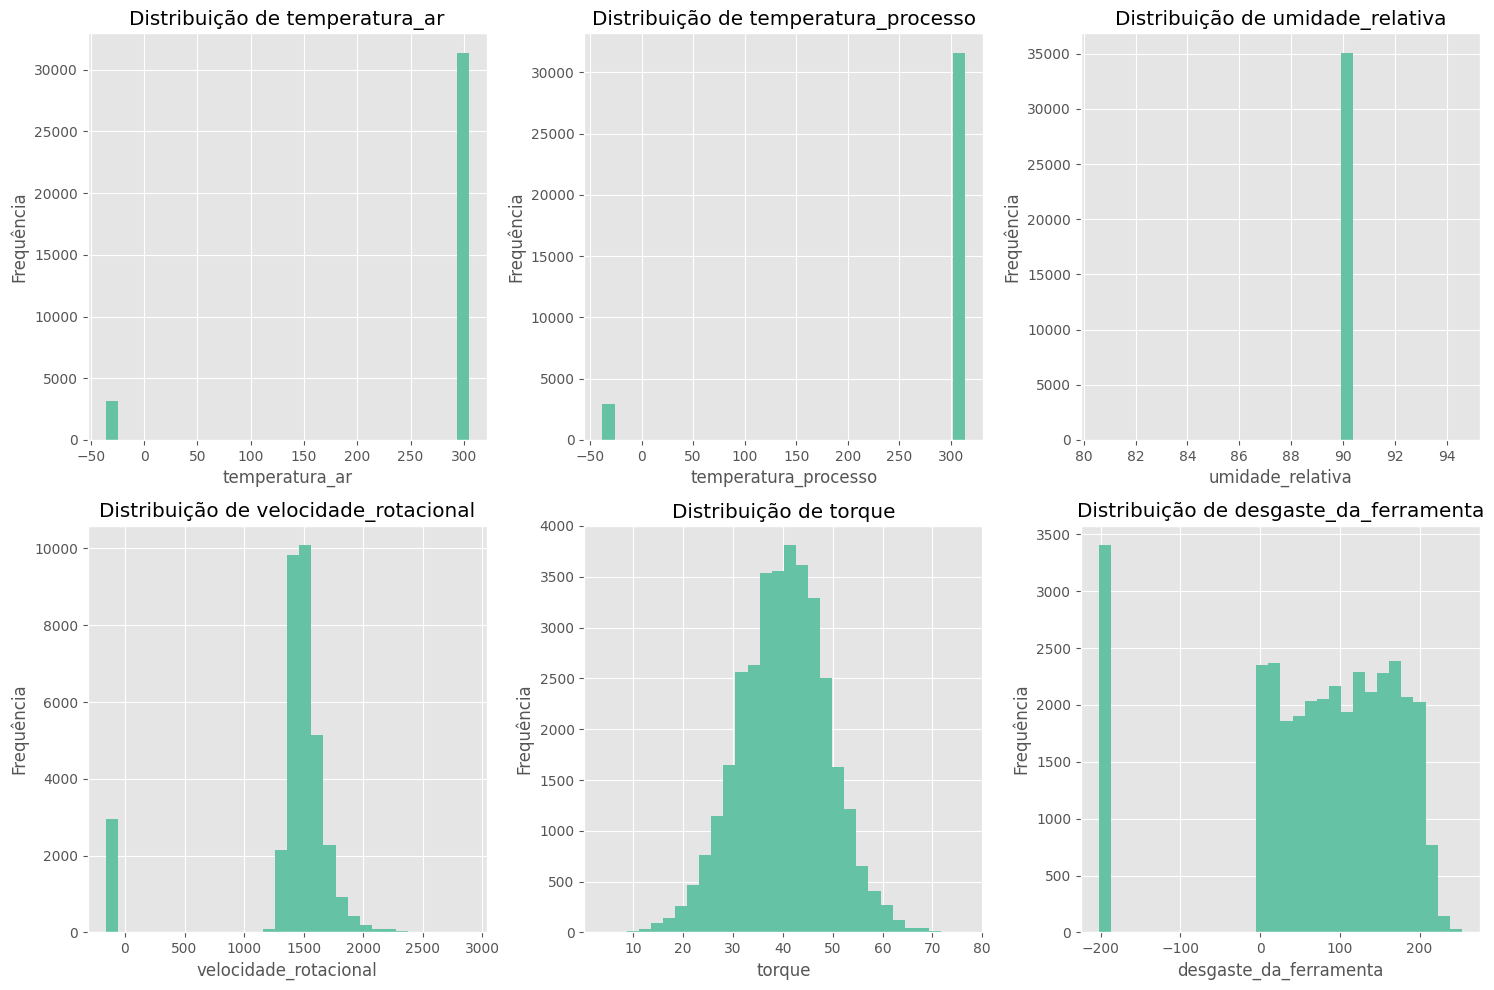

In [16]:
# Visualização da distribuição das features numéricas
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, col in enumerate(numeric_cols):
    if col in df.columns:
        df[col].hist(bins=30, ax=axes[i])
        axes[i].set_title(f'Distribuição de {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequência')

plt.tight_layout()
plt.show()

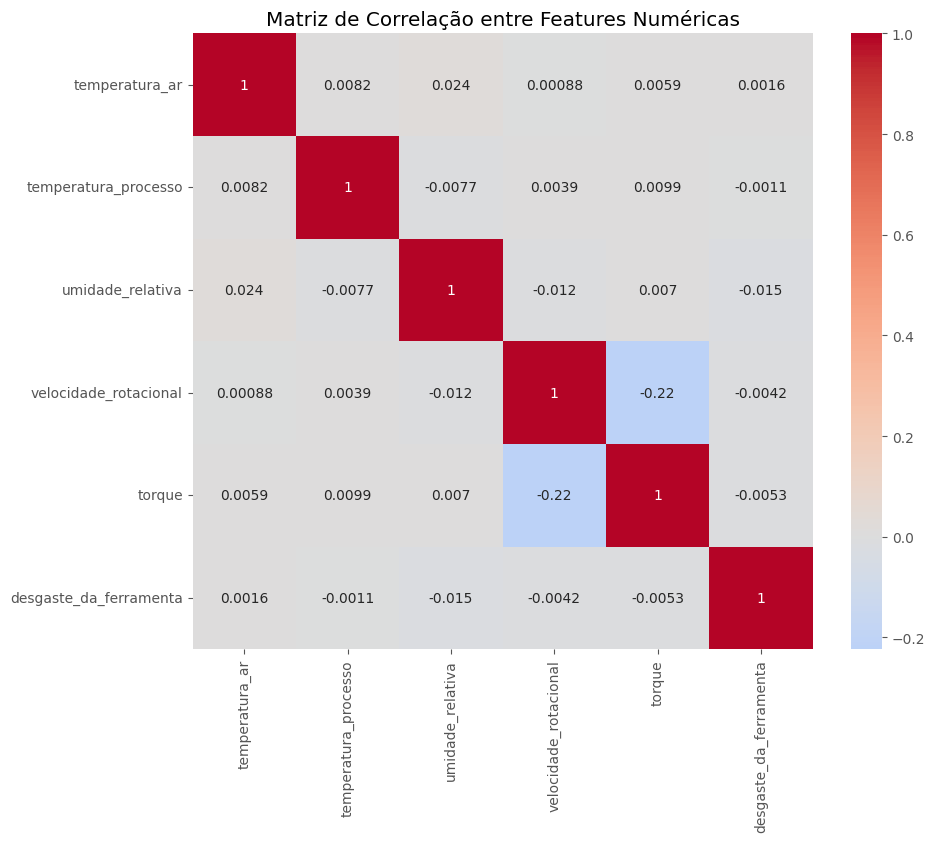

In [17]:
# Análise de correlação
correlation_matrix = df[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlação entre Features Numéricas')
plt.show()

In [18]:
# Análise do desbalanceamento das classes
print("=== ANÁLISE DE DESBALANCEAMENTO DAS CLASSES ===")
for col in failure_cols:
    if col in df.columns:
        counts = df[col].value_counts()
        print(f"\n{col}:")
        print(f"  0: {counts.get(0, 0)} amostras ({counts.get(0, 0)/len(df)*100:.2f}%)")
        print(f"  1: {counts.get(1, 0)} amostras ({counts.get(1, 0)/len(df)*100:.2f}%)")

=== ANÁLISE DE DESBALANCEAMENTO DAS CLASSES ===

FDF (Falha Desgaste Ferramenta):
  0: 35049 amostras (99.80%)
  1: 71 amostras (0.20%)

FDC (Falha Dissipacao Calor):
  0: 34897 amostras (99.37%)
  1: 223 amostras (0.63%)

FP (Falha Potencia):
  0: 34994 amostras (99.64%)
  1: 126 amostras (0.36%)

FTE (Falha Tensao Excessiva):
  0: 34951 amostras (99.52%)
  1: 169 amostras (0.48%)

FA (Falha Aleatoria):
  0: 35046 amostras (99.79%)
  1: 74 amostras (0.21%)


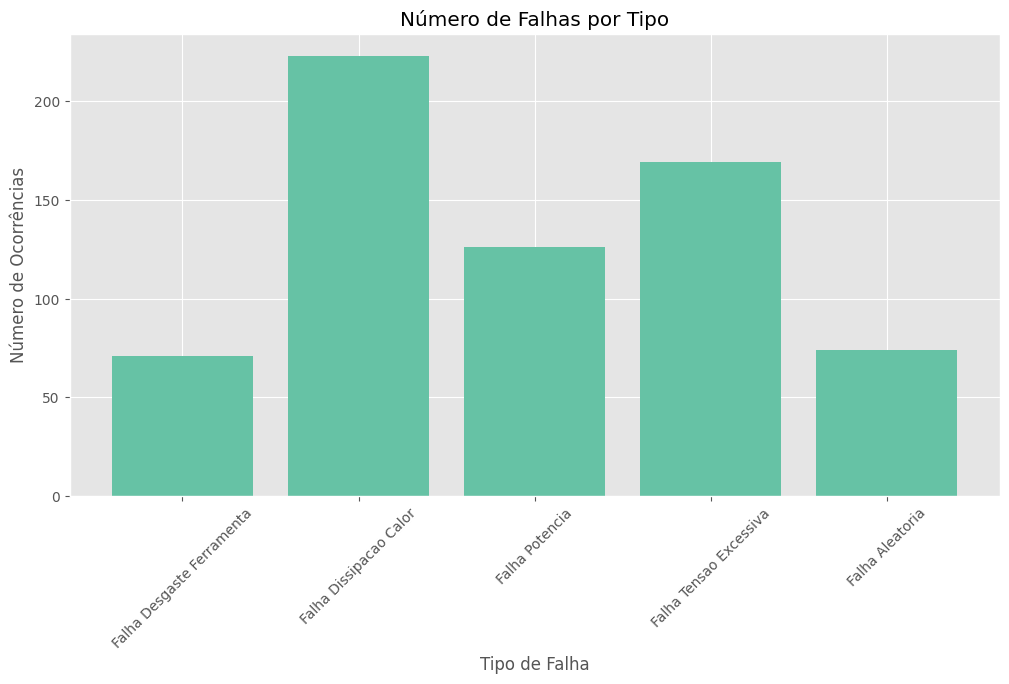

In [19]:
# Visualização do desbalanceamento
failure_counts = [df[col].sum() for col in failure_cols if col in df.columns]
failure_names = [col.split('(')[1].split(')')[0] for col in failure_cols if col in df.columns]

plt.figure(figsize=(12, 6))
plt.bar(failure_names, failure_counts)
plt.title('Número de Falhas por Tipo')
plt.xlabel('Tipo de Falha')
plt.ylabel('Número de Ocorrências')
plt.xticks(rotation=45)
plt.show()

In [20]:
# Análise de falhas múltiplas
df['total_falhas'] = df[failure_cols].sum(axis=1)
multiple_failures = df[df['total_falhas'] > 1]
print(f"\nNúmero de amostras com múltiplas falhas: {len(multiple_failures)}")
print(f"Percentual: {len(multiple_failures)/len(df)*100:.2f}%")


Número de amostras com múltiplas falhas: 17
Percentual: 0.05%


In [21]:
# Pré-processamento dos dados
print("\n=== PRÉ-PROCESSAMENTO DOS DADOS ===")


=== PRÉ-PROCESSAMENTO DOS DADOS ===


In [22]:
# Separar features e targets
X = df.drop(columns=['id', 'id_produto'] + failure_cols + ['falha_maquina', 'total_falhas'], errors='ignore')
y = df[failure_cols]

In [23]:
# Codificar variável categórica 'tipo'
if 'tipo' in X.columns:
    le = LabelEncoder()
    X['tipo'] = le.fit_transform(X['tipo'].astype(str))

In [24]:
# Identificar valores ausentes
print("Valores ausentes antes do tratamento:")
print(X.isnull().sum())

Valores ausentes antes do tratamento:
tipo                        0
temperatura_ar            614
temperatura_processo      597
umidade_relativa            0
velocidade_rotacional     746
torque                    619
desgaste_da_ferramenta    950
dtype: int64


In [25]:
# Estratégia de imputação
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

In [26]:
# Imputação para features numéricas
numeric_imputer = SimpleImputer(strategy='median')
X_numeric_imputed = numeric_imputer.fit_transform(X[numeric_features])

In [27]:
# Imputação para features categóricas (se houver)
if categorical_features:
    categorical_imputer = SimpleImputer(strategy='most_frequent')
    X_categorical_imputed = categorical_imputer.fit_transform(X[categorical_features])
    X_imputed = np.concatenate([X_numeric_imputed, X_categorical_imputed], axis=1)
else:
    X_imputed = X_numeric_imputed

In [28]:
# Normalização das features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

In [29]:
# # Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=df['falha_maquina']
)

print(f"\nDimensões dos conjuntos:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

# Verificar se há NaN no y_train e y_test
print(f"\nValores NaN em y_train: {y_train.isnull().sum().sum()}")
print(f"Valores NaN em y_test: {y_test.isnull().sum().sum()}")

# Definição das métricas de avaliação
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    
    print(f"\n=== AVALIAÇÃO DO MODELO: {model_name} ===")
    
    # Métricas para cada classe
    for i, col in enumerate(y_test.columns):
        print(f"\n--- {col} ---")
        print(f"Acurácia: {accuracy_score(y_test.iloc[:, i], y_pred[:, i]):.4f}")
        print(f"Precisão: {precision_score(y_test.iloc[:, i], y_pred[:, i], zero_division=0):.4f}")
        print(f"Recall: {recall_score(y_test.iloc[:, i], y_pred[:, i], zero_division=0):.4f}")
        print(f"F1-Score: {f1_score(y_test.iloc[:, i], y_pred[:, i], zero_division=0):.4f}")
        
        # ROC AUC (se disponível)
        try:
            y_pred_proba = model.predict_proba(X_test)
            roc_auc = roc_auc_score(y_test.iloc[:, i], y_pred_proba[i][:, 1])
            print(f"ROC AUC: {roc_auc:.4f}")
        except:
            print("ROC AUC: Não disponível")
    
    # Média das métricas
    print(f"\n--- MÉTRICAS MÉDIAS ---")
    print(f"Acurácia Média: {np.mean([accuracy_score(y_test.iloc[:, i], y_pred[:, i]) for i in range(y_test.shape[1])]):.4f}")
    print(f"Precisão Média: {np.mean([precision_score(y_test.iloc[:, i], y_pred[:, i], zero_division=0) for i in range(y_test.shape[1])]):.4f}")
    print(f"Recall Médio: {np.mean([recall_score(y_test.iloc[:, i], y_pred[:, i], zero_division=0) for i in range(y_test.shape[1])]):.4f}")
    print(f"F1-Score Médio: {np.mean([f1_score(y_test.iloc[:, i], y_pred[:, i], zero_division=0) for i in range(y_test.shape[1])]):.4f}")


Dimensões dos conjuntos:
X_train: (28096, 7), y_train: (28096, 5)
X_test: (7024, 7), y_test: (7024, 5)

Valores NaN em y_train: 0
Valores NaN em y_test: 0


In [30]:
# Modelos a serem testados
models = {
    'Random Forest': MultiOutputClassifier(RandomForestClassifier(n_estimators=100, random_state=42)),
    'Gradient Boosting': MultiOutputClassifier(GradientBoostingClassifier(random_state=42)),
    'XGBoost': MultiOutputClassifier(xgb.XGBClassifier(random_state=42)),
    'LightGBM': MultiOutputClassifier(lgb.LGBMClassifier(random_state=42)),
    'CatBoost': MultiOutputClassifier(CatBoostClassifier(random_state=42, verbose=0))
}

In [31]:
# Treinamento e avaliação dos modelos
results = {}
for name, model in models.items():
    print(f"\nTreinando {name}...")
    model.fit(X_train, y_train)
    results[name] = model
    evaluate_model(model, X_test, y_test, name)


Treinando Random Forest...

=== AVALIAÇÃO DO MODELO: Random Forest ===

--- FDF (Falha Desgaste Ferramenta) ---
Acurácia: 0.9974
Precisão: 0.0000
Recall: 0.0000
F1-Score: 0.0000
ROC AUC: 0.6534

--- FDC (Falha Dissipacao Calor) ---
Acurácia: 0.9942
Precisão: 0.8667
Recall: 0.2500
F1-Score: 0.3881
ROC AUC: 0.9499

--- FP (Falha Potencia) ---
Acurácia: 0.9979
Precisão: 0.7857
Recall: 0.4783
F1-Score: 0.5946
ROC AUC: 0.9307

--- FTE (Falha Tensao Excessiva) ---
Acurácia: 0.9960
Precisão: 0.5000
Recall: 0.1071
F1-Score: 0.1765
ROC AUC: 0.9500

--- FA (Falha Aleatoria) ---
Acurácia: 0.9974
Precisão: 0.0000
Recall: 0.0000
F1-Score: 0.0000
ROC AUC: 0.5037

--- MÉTRICAS MÉDIAS ---
Acurácia Média: 0.9966
Precisão Média: 0.4305
Recall Médio: 0.1671
F1-Score Médio: 0.2318

Treinando Gradient Boosting...

=== AVALIAÇÃO DO MODELO: Gradient Boosting ===

--- FDF (Falha Desgaste Ferramenta) ---
Acurácia: 0.9970
Precisão: 0.0000
Recall: 0.0000
F1-Score: 0.0000
ROC AUC: 0.8545

--- FDC (Falha Dissipac

In [32]:
# CORREÇÃO: Estratégia alternativa para lidar com desbalanceamento em problemas multioutput
# Vamos criar uma abordagem personalizada para balanceamento
print("\n=== ESTRATÉGIA DE BALANCEAMENTO PERSONALIZADA ===")


=== ESTRATÉGIA DE BALANCEAMENTO PERSONALIZADA ===


In [33]:
# Função para aplicar balanceamento individual para cada classe
def balanced_multioutput_training(X_train, y_train, base_estimator):
    """
    Treina um classificador separado para cada classe com balanceamento individual
    """
    from imblearn.over_sampling import SMOTE
    from collections import defaultdict
    
    classifiers = {}
    smote_instances = {}
    
    # Treinar um classificador separado para cada classe alvo
    for i, col in enumerate(y_train.columns):
        print(f"  Treinando para {col}...")
        
        # Aplicar SMOTE apenas para esta classe específica
        smote = SMOTE(random_state=42)
        X_resampled, y_resampled = smote.fit_resample(X_train, y_train.iloc[:, i])
        
        # Treinar o classificador
        classifier = base_estimator
        classifier.fit(X_resampled, y_resampled)
        
        classifiers[col] = classifier
        smote_instances[col] = smote
    
    return classifiers

In [34]:
# Treinar Random Forest com balanceamento individual
print("Treinando Random Forest com balanceamento individual por classe...")
rf_classifiers = balanced_multioutput_training(
    X_train, y_train, 
    RandomForestClassifier(n_estimators=100, random_state=42)
)

Treinando Random Forest com balanceamento individual por classe...
  Treinando para FDF (Falha Desgaste Ferramenta)...
  Treinando para FDC (Falha Dissipacao Calor)...
  Treinando para FP (Falha Potencia)...
  Treinando para FTE (Falha Tensao Excessiva)...
  Treinando para FA (Falha Aleatoria)...


In [35]:
# Função de predição para o modelo balanceado
def predict_balanced_model(classifiers, X_test):
    """
    Faz previsões usando os classificadores treinados individualmente
    """
    predictions = np.zeros((X_test.shape[0], len(classifiers)))
    
    for i, (col, classifier) in enumerate(classifiers.items()):
        predictions[:, i] = classifier.predict(X_test)
    
    return predictions

In [37]:
# Avaliar o modelo balanceado
y_pred_balanced = predict_balanced_model(rf_classifiers, X_test)

print("\n=== AVALIAÇÃO DO MODELO COM BALANCEAMENTO INDIVIDUAL ===")
for i, col in enumerate(y_test.columns):
    print(f"\n--- {col} ---")
    print(f"Acurácia: {accuracy_score(y_test.iloc[:, i], y_pred_balanced[:, i]):.4f}")
    print(f"Precisão: {precision_score(y_test.iloc[:, i], y_pred_balanced[:, i], zero_division=0):.4f}")
    print(f"Recall: {recall_score(y_test.iloc[:, i], y_pred_balanced[:, i], zero_division=0):.4f}")
    print(f"F1-Score: {f1_score(y_test.iloc[:, i], y_pred_balanced[:, i], zero_division=0):.4f}")

# Adicionar ao dicionário de resultados
class BalancedMultiOutputModel:
    def __init__(self, classifiers):
        self.classifiers = classifiers
        self.classes_ = list(classifiers.keys())
    
    def predict(self, X):
        return predict_balanced_model(self.classifiers, X)
    
    def predict_proba(self, X):
        probabilities = np.zeros((X.shape[0], len(self.classifiers), 2))
        
        for i, (col, classifier) in enumerate(self.classifiers.items()):
            try:
                proba = classifier.predict_proba(X)
                probabilities[:, i, :] = proba
            except:
                # Se o classificador não tiver predict_proba, usar aproximação
                pred = classifier.predict(X)
                probabilities[:, i, 0] = 1 - pred
                probabilities[:, i, 1] = pred
        
        return probabilities

balanced_model = BalancedMultiOutputModel(rf_classifiers)
results['Random Forest Balanced'] = balanced_model


=== AVALIAÇÃO DO MODELO COM BALANCEAMENTO INDIVIDUAL ===

--- FDF (Falha Desgaste Ferramenta) ---
Acurácia: 0.9902
Precisão: 0.0000
Recall: 0.0000
F1-Score: 0.0000

--- FDC (Falha Dissipacao Calor) ---
Acurácia: 0.9852
Precisão: 0.0000
Recall: 0.0000
F1-Score: 0.0000

--- FP (Falha Potencia) ---
Acurácia: 0.9893
Precisão: 0.0000
Recall: 0.0000
F1-Score: 0.0000

--- FTE (Falha Tensao Excessiva) ---
Acurácia: 0.9886
Precisão: 0.0000
Recall: 0.0000
F1-Score: 0.0000

--- FA (Falha Aleatoria) ---
Acurácia: 0.9900
Precisão: 0.0000
Recall: 0.0000
F1-Score: 0.0000


In [38]:
# Seleção do melhor modelo baseado no F1-Score médio
best_model_name = None
best_f1_score = 0

for name, model in results.items():
    if hasattr(model, 'predict'):
        y_pred = model.predict(X_test)
        f1_scores = [f1_score(y_test.iloc[:, i], y_pred[:, i], zero_division=0) for i in range(y_test.shape[1])]
        avg_f1 = np.mean(f1_scores)
        
        if avg_f1 > best_f1_score:
            best_f1_score = avg_f1
            best_model_name = name

print(f"\n=== MELHOR MODELO ===")
print(f"Modelo: {best_model_name}")
print(f"F1-Score Médio: {best_f1_score:.4f}")

best_model = results[best_model_name]


=== MELHOR MODELO ===
Modelo: XGBoost
F1-Score Médio: 0.2722



=== AVALIAÇÃO FINAL DO MELHOR MODELO ===

--- FDF (Falha Desgaste Ferramenta) ---
Acurácia: 0.9976
Precisão: 0.5000
Recall: 0.0588
F1-Score: 0.1053

--- FDC (Falha Dissipacao Calor) ---
Acurácia: 0.9946
Precisão: 0.7188
Recall: 0.4423
F1-Score: 0.5476

--- FP (Falha Potencia) ---
Acurácia: 0.9976
Precisão: 0.8750
Recall: 0.3043
F1-Score: 0.4516

--- FTE (Falha Tensao Excessiva) ---
Acurácia: 0.9959
Precisão: 0.4545
Recall: 0.1786
F1-Score: 0.2564

--- FA (Falha Aleatoria) ---
Acurácia: 0.9974
Precisão: 0.0000
Recall: 0.0000
F1-Score: 0.0000


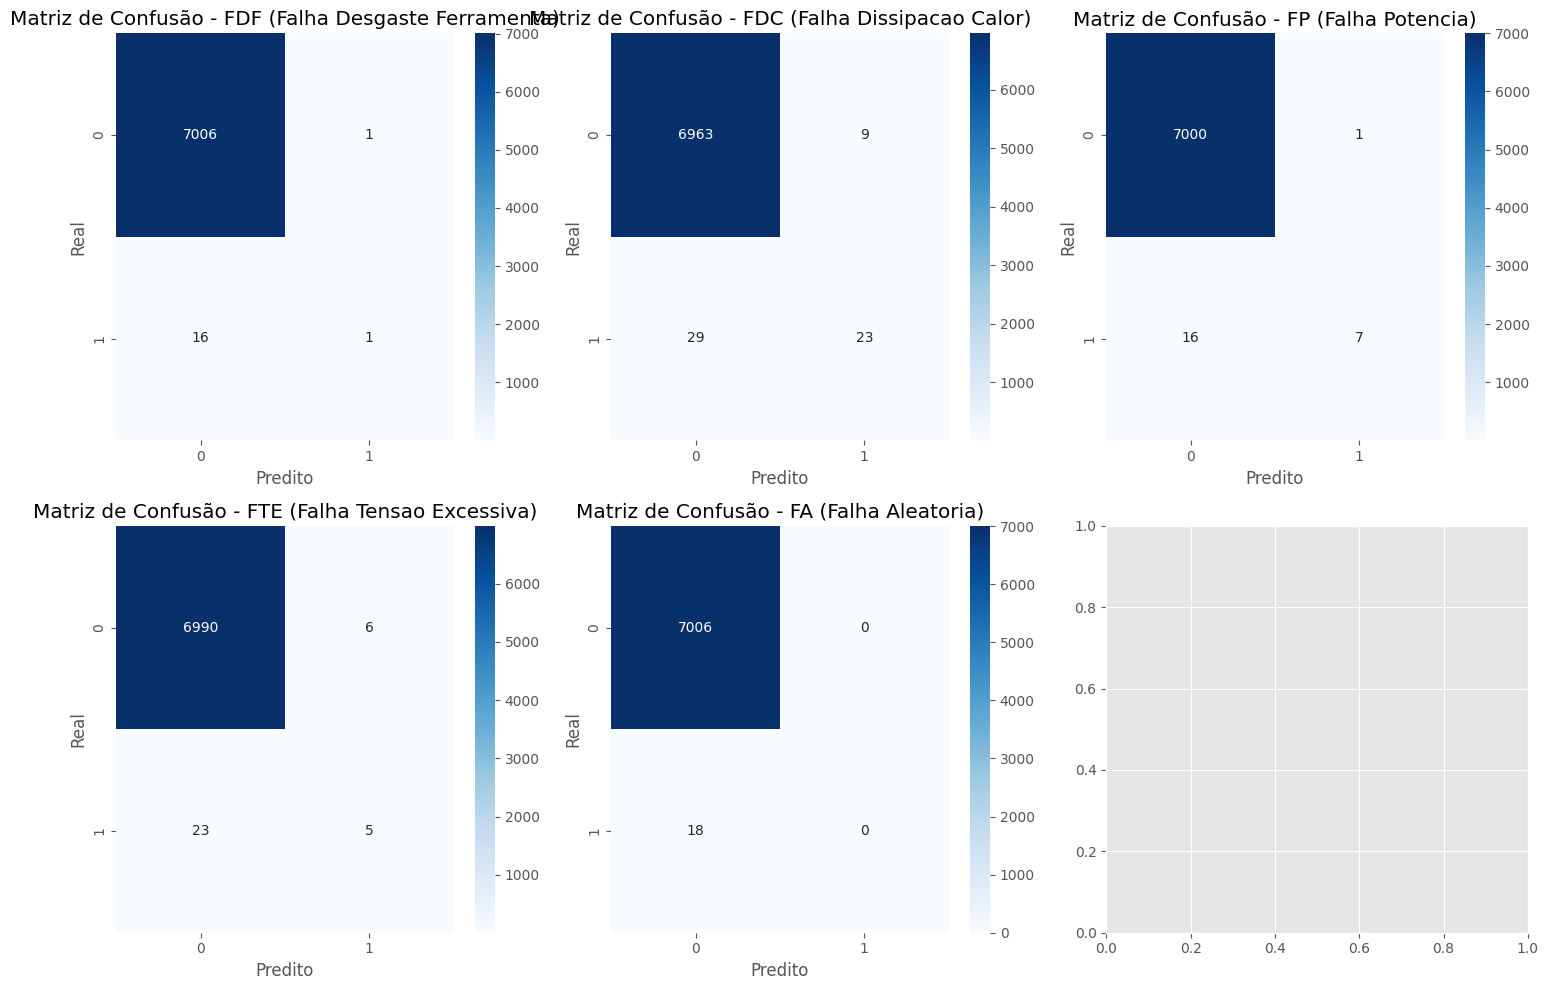

In [39]:
# Avaliação final do melhor modelo
print("\n=== AVALIAÇÃO FINAL DO MELHOR MODELO ===")

if hasattr(best_model, 'predict'):
    y_pred_final = best_model.predict(X_test)
    
    for i, col in enumerate(y_test.columns):
        print(f"\n--- {col} ---")
        print(f"Acurácia: {accuracy_score(y_test.iloc[:, i], y_pred_final[:, i]):.4f}")
        print(f"Precisão: {precision_score(y_test.iloc[:, i], y_pred_final[:, i], zero_division=0):.4f}")
        print(f"Recall: {recall_score(y_test.iloc[:, i], y_pred_final[:, i], zero_division=0):.4f}")
        print(f"F1-Score: {f1_score(y_test.iloc[:, i], y_pred_final[:, i], zero_division=0):.4f}")

# Matriz de confusão para cada classe
if hasattr(best_model, 'predict'):
    y_pred_final = best_model.predict(X_test)
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()

    for i, col in enumerate(y_test.columns):
        cm = confusion_matrix(y_test.iloc[:, i], y_pred_final[:, i])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
        axes[i].set_title(f'Matriz de Confusão - {col}')
        axes[i].set_xlabel('Predito')
        axes[i].set_ylabel('Real')

    plt.tight_layout()
    plt.show()

In [41]:
# Preparação para submissão na API
print("\n=== PREPARAÇÃO PARA SUBMISSÃO ===")


=== PREPARAÇÃO PARA SUBMISSÃO ===


In [43]:
# Carregar dados de teste
test_df = pd.read_csv('bootcamp_test.csv')

In [45]:
# Pré-processamento dos dados de teste
X_test_submission = test_df.drop(columns=['id', 'id_produto'], errors='ignore')

if 'tipo' in X_test_submission.columns:
    X_test_submission['tipo'] = le.transform(X_test_submission['tipo'].astype(str))

In [46]:
# Imputação e scaling
X_test_numeric_imputed = numeric_imputer.transform(X_test_submission[numeric_features])

if categorical_features:
    X_test_categorical_imputed = categorical_imputer.transform(X_test_submission[categorical_features])
    X_test_imputed = np.concatenate([X_test_numeric_imputed, X_test_categorical_imputed], axis=1)
else:
    X_test_imputed = X_test_numeric_imputed

X_test_scaled = scaler.transform(X_test_imputed)

In [48]:
# Fazer previsões
if hasattr(best_model, 'predict'):
    y_pred_submission = best_model.predict(X_test_scaled)
    
    # Criar dataframe de submissão
    submission_df = test_df[['id']].copy()
    for i, col in enumerate(failure_cols):
        submission_df[col] = y_pred_submission[:, i]
    
    # Salvar resultados
    submission_df.to_csv('submission_predictions.csv', index=False)
    print("Arquivo de submissão salvo como 'submission_predictions.csv'")

    # Análise das previsões
    print("\n=== ANÁLISE DAS PREVISÕES ===")
    print(f"Total de previsões: {len(submission_df)}")
    for col in failure_cols:
        if col in submission_df.columns:
            count = submission_df[col].sum()
            print(f"{col}: {count} previsões positivas ({count/len(submission_df)*100:.2f}%)")

print("\n=== PROJETO CONCLUÍDO ===")
print("Análise completa realizada e modelo treinado com sucesso!")
print(f"Melhor modelo: {best_model_name}")
print("Arquivo de submissão gerado: 'submission_predictions.csv'")

Arquivo de submissão salvo como 'submission_predictions.csv'

=== ANÁLISE DAS PREVISÕES ===
Total de previsões: 7173
FDF (Falha Desgaste Ferramenta): 3 previsões positivas (0.04%)
FDC (Falha Dissipacao Calor): 81 previsões positivas (1.13%)
FP (Falha Potencia): 24 previsões positivas (0.33%)
FTE (Falha Tensao Excessiva): 29 previsões positivas (0.40%)
FA (Falha Aleatoria): 2 previsões positivas (0.03%)

=== PROJETO CONCLUÍDO ===
Análise completa realizada e modelo treinado com sucesso!
Melhor modelo: XGBoost
Arquivo de submissão gerado: 'submission_predictions.csv'
